In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ============================================================================
# CELL 1: Install Dependencies
# ============================================================================

!pip install -q transformers datasets evaluate accelerate
print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
✓ Dependencies installed


In [3]:
import transformers
print(f"Current transformers version: {transformers.__version__}")

# If version is old (< 4.30), upgrade it
if transformers.__version__ < "4.30":
    print("Upgrading transformers to latest version...")
    !pip install -q --upgrade transformers
    print("Please restart the kernel and run again!")
else:
    print("✓ Transformers version is compatible")

Current transformers version: 4.57.1
✓ Transformers version is compatible


In [4]:
# ============================================================================
# CELL 2: Setup Paths and Verify Dataset
# ============================================================================

import os
from pathlib import Path

# Kaggle directories
KAGGLE_INPUT = Path('/kaggle/input')
KAGGLE_WORKING = Path('/kaggle/working')

print("Available datasets in /kaggle/input:")
for item in os.listdir(KAGGLE_INPUT):
    print(f"  📁 {item}")

# DATASET PATHS - Updated to match your Kaggle dataset location
DATASET_NAME = 'offroad-segmentation'

# Full base path to your dataset
BASE_DIR = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset')

# Dataset paths - Direct paths to your data
dir_train_img = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Color_Images')
dir_train_mask = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Segmentation')
dir_val_img = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Color_Images')
dir_val_mask = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Segmentation')

# Output paths
dir_output = KAGGLE_WORKING / 'segformer_outputs'
dir_output.mkdir(parents=True, exist_ok=True)

# Verify paths
print("\n" + "="*60)
print("VERIFICATION:")
print("="*60)
print(f"✓ Train images: {dir_train_img.exists()} - {dir_train_img}")
print(f"✓ Train masks:  {dir_train_mask.exists()} - {dir_train_mask}")
print(f"✓ Val images:   {dir_val_img.exists()} - {dir_val_img}")
print(f"✓ Val masks:    {dir_val_mask.exists()} - {dir_val_mask}")

# Count samples
if dir_train_img.exists():
    train_count = len(list(dir_train_img.glob('*.png')))
    val_count = len(list(dir_val_img.glob('*.png')))
    
    print(f"\n📊 Dataset size:")
    print(f"   Training samples:   {train_count}")
    print(f"   Validation samples: {val_count}")
else:
    print("\n⚠️  ERROR: Dataset not found!")
    print("Please check the paths above.")

Available datasets in /kaggle/input:
  📁 competitions
  📁 datasets

VERIFICATION:
✓ Train images: True - /kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Color_Images
✓ Train masks:  True - /kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Segmentation
✓ Val images:   True - /kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Color_Images
✓ Val masks:    True - /kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Segmentation

📊 Dataset size:
   Training samples:   2857
   Validation samples: 317


In [5]:
# ============================================================================
# CELL 3: Import Libraries & Check GPU
# ============================================================================

import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import evaluate
import gc

from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation,
    TrainingArguments,
    Trainer
)

# Set matplotlib backend
plt.switch_backend('inline')

# Check device and GPU count
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_count = torch.cuda.device_count() if torch.cuda.is_available() else 0

print("="*60)
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU Count: {gpu_count}")
    for i in range(gpu_count):
        print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"   Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
    print(f"🔢 CUDA Version: {torch.version.cuda}")
    
    # Clear any existing GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    print("✓ GPU cache cleared")
else:
    print("⚠️  WARNING: GPU not available! Training will be very slow.")
print("="*60)

2026-02-15 10:47:07.030544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771152427.158650      44 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771152427.193784      44 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771152427.499721      44 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771152427.499744      44 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771152427.499746      44 computation_placer.cc:177] computation placer alr

🖥️  Device: cuda
🎮 GPU Count: 1
   GPU 0: NVIDIA H100 80GB HBM3
   Memory: 85.02 GB
🔢 CUDA Version: 12.6
✓ GPU cache cleared


In [6]:
# ============================================================================
# CELL 4: Class Mapping & Helper Functions
# ============================================================================

# Class mapping from organizers (10 classes)
value_map = {
    0: 0,        # background
    100: 1,      # Trees
    200: 2,      # Lush Bushes
    300: 3,      # Dry Grass
    500: 4,      # Dry Bushes
    550: 5,      # Ground Clutter
    700: 6,      # Logs
    800: 7,      # Rocks
    7100: 8,     # Landscape
    10000: 9     # Sky
}

id2label = {
    0: "background",
    1: "Trees",
    2: "Lush Bushes",
    3: "Dry Grass",
    4: "Dry Bushes",
    5: "Ground Clutter",
    6: "Logs",
    7: "Rocks",
    8: "Landscape",
    9: "Sky"
}

label2id = {v: k for k, v in id2label.items()}
n_classes = len(value_map)

print(f"Number of classes: {n_classes}")
print("\nClass mapping:")
for i in range(n_classes):
    print(f"  Class {i}: {id2label[i]}")


def convert_mask(mask):
    """Convert raw mask values to class IDs."""
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in value_map.items():
        new_arr[arr == raw_value] = new_value
    return new_arr


print("✓ Helper functions defined")


Number of classes: 10

Class mapping:
  Class 0: background
  Class 1: Trees
  Class 2: Lush Bushes
  Class 3: Dry Grass
  Class 4: Dry Bushes
  Class 5: Ground Clutter
  Class 6: Logs
  Class 7: Rocks
  Class 8: Landscape
  Class 9: Sky
✓ Helper functions defined


In [7]:
# ============================================================================
# CELL 5: Dataset Class
# ============================================================================

class OffroadSegmentationDataset(Dataset):
    """Dataset for offroad segmentation with SegFormer preprocessing."""
    
    def __init__(self, img_dir, mask_dir, image_processor):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.image_processor = image_processor
        self.ids = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        # Load image and mask
        image = Image.open(self.img_dir / img_id).convert("RGB")
        mask = Image.open(self.mask_dir / img_id)
        
        # Convert mask to class IDs
        mask = convert_mask(mask)
        
        # Apply image processor (handles resizing, normalization, etc.)
        encoded = self.image_processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )
        
        # Remove batch dimension
        encoded = {k: v.squeeze(0) for k, v in encoded.items()}
        
        return encoded


print("✓ Dataset class defined")

✓ Dataset class defined


In [8]:
# ============================================================================
# CELL 6: Metrics Functions
# ============================================================================

def make_json_serializable(obj):
    """Recursively convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    else:
        return obj


def compute_metrics(eval_pred):
    """Compute mIoU, pixel accuracy, and Dice score."""
    
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        
        # Scale logits to label size
        logits_tensor = torch.nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        
        # Clear memory
        del logits_tensor
        torch.cuda.empty_cache()
        
        # Compute IoU
        metric = evaluate.load("mean_iou")
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=n_classes,
            ignore_index=255,
            reduce_labels=False,
        )
        
        # Extract and convert per-class IoU
        per_class_iou = metrics.pop("per_category_iou", None)
        if per_class_iou is not None:
            per_class_iou = per_class_iou.tolist() if isinstance(per_class_iou, np.ndarray) else per_class_iou
            for class_id, iou in enumerate(per_class_iou):
                if iou is not None and not (isinstance(iou, float) and np.isnan(iou)):
                    metrics[f"iou_class_{class_id}"] = float(iou)
                else:
                    metrics[f"iou_class_{class_id}"] = 0.0
        
        # Compute pixel accuracy
        pixel_accuracy = float((pred_labels == labels).sum() / labels.size)
        metrics["pixel_accuracy"] = pixel_accuracy
        
        # Compute Dice score (F1)
        dice_scores = []
        for class_id in range(n_classes):
            pred_mask = (pred_labels == class_id)
            true_mask = (labels == class_id)
            intersection = (pred_mask & true_mask).sum()
            union = pred_mask.sum() + true_mask.sum()
            if union > 0:
                dice = float((2.0 * intersection) / union)
                dice_scores.append(dice)
        
        if dice_scores:
            metrics["dice_score"] = float(np.mean(dice_scores))
        else:
            metrics["dice_score"] = 0.0
        
        # CRITICAL: Recursively convert ALL values to JSON-serializable types
        metrics = make_json_serializable(metrics)
        
        return metrics


print("✓ Metrics functions defined")
# ============================================================================
# CELL 6.5: Test Dataset Configuration (ADD AFTER CELL 6)
# ============================================================================

# Test dataset path
TEST_DIR = Path('/kaggle/input/datasets/somanshu7527/sementation-test-images/Offroad_Segmentation_testImages')
dir_test_img = TEST_DIR / 'Color_Images'
dir_test_mask = TEST_DIR / 'Segmentation'

print(f"✓ Test images: {dir_test_img.exists()} - {dir_test_img}")
print(f"✓ Test masks:  {dir_test_mask.exists()} - {dir_test_mask}")

if dir_test_img.exists():
    test_count = len(list(dir_test_img.glob('*.png')))
    print(f"   Test samples: {test_count}")

✓ Metrics functions defined
✓ Test images: True - /kaggle/input/datasets/somanshu7527/sementation-test-images/Offroad_Segmentation_testImages/Color_Images
✓ Test masks:  True - /kaggle/input/datasets/somanshu7527/sementation-test-images/Offroad_Segmentation_testImages/Segmentation
   Test samples: 1002


In [9]:
# ============================================================================
# CELL 7: Plotting Functions
# ============================================================================

def save_training_plots(trainer, output_dir):
    """Save training curves."""
    history = trainer.state.log_history
    output_dir = Path(output_dir)
    
    # Extract metrics
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    eval_iou = [x['eval_mean_iou'] for x in history if 'eval_mean_iou' in x]
    eval_acc = [x['eval_pixel_accuracy'] for x in history if 'eval_pixel_accuracy' in x]
    eval_dice = [x['eval_dice_score'] for x in history if 'eval_dice_score' in x]
    
    epochs = list(range(1, len(eval_loss) + 1))
    
    # Plot 1: Loss curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(train_loss, label='train', alpha=0.7)
    ax1.plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss, 
             label='val', marker='o')
    ax1.set_title('Loss')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, eval_acc, label='val', marker='o')
    ax2.set_title('Pixel Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot 2: IoU curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(epochs, eval_iou, label='Val IoU', marker='o')
    ax1.set_title('Mean IoU vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('IoU')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, eval_dice, label='Val Dice', marker='o', color='green')
    ax2.set_title('Dice Score vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'iou_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot 3: Dice curves (separate)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(epochs, eval_dice, label='Val Dice', marker='o', color='green', linewidth=2)
    ax.set_title('Validation Dice Score vs Epoch', fontsize=14)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Dice Score')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(output_dir / 'dice_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot 4: Combined metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    axes[0, 0].plot(train_loss, label='train', alpha=0.7)
    axes[0, 0].plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss, 
                    label='val', marker='o')
    axes[0, 0].set_title('Loss vs Steps')
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # IoU
    axes[0, 1].plot(epochs, eval_iou, label='val', marker='o')
    axes[0, 1].set_title('Mean IoU vs Epoch')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Dice
    axes[1, 0].plot(epochs, eval_dice, label='val', marker='o', color='green')
    axes[1, 0].set_title('Dice Score vs Epoch')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Pixel Accuracy
    axes[1, 1].plot(epochs, eval_acc, label='val', marker='o', color='orange')
    axes[1, 1].set_title('Pixel Accuracy vs Epoch')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'all_metrics_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"✓ Training curves saved to {output_dir}")


def save_history_to_file(trainer, output_dir):
    """Save detailed metrics to text file."""
    history = trainer.state.log_history
    output_dir = Path(output_dir)
    
    eval_metrics = [x for x in history if 'eval_loss' in x]
    
    filepath = output_dir / 'evaluation_metrics.txt'
    with open(filepath, 'w') as f:
        f.write("TRAINING RESULTS - SegFormer Model\n")
        f.write("=" * 80 + "\n\n")
        
        # Final metrics
        final = eval_metrics[-1]
        f.write("Final Metrics:\n")
        f.write(f"  Final Val Loss:       {final['eval_loss']:.4f}\n")
        f.write(f"  Final Val mIoU:       {final['eval_mean_iou']:.4f}\n")
        f.write(f"  Final Val Dice:       {final['eval_dice_score']:.4f}\n")
        f.write(f"  Final Val Accuracy:   {final['eval_pixel_accuracy']:.4f}\n")
        f.write("=" * 80 + "\n\n")
        
        # Best metrics
        best_iou_idx = np.argmax([x['eval_mean_iou'] for x in eval_metrics])
        best_iou = eval_metrics[best_iou_idx]
        
        f.write("Best Results:\n")
        f.write(f"  Best Val mIoU:     {best_iou['eval_mean_iou']:.4f} (Epoch {best_iou_idx + 1})\n")
        f.write(f"  Best Val Dice:     {best_iou['eval_dice_score']:.4f}\n")
        f.write(f"  Best Val Accuracy: {best_iou['eval_pixel_accuracy']:.4f}\n")
        f.write("=" * 80 + "\n\n")
        
        # Per-class IoU from best epoch
        f.write("Per-Class IoU (Best Epoch):\n")
        for i in range(n_classes):
            if f'eval_iou_class_{i}' in best_iou:
                f.write(f"  {id2label[i]:20s}: {best_iou[f'eval_iou_class_{i}']:.4f}\n")
        f.write("=" * 80 + "\n\n")
        
        # Epoch history
        f.write("Per-Epoch History:\n")
        f.write("-" * 100 + "\n")
        f.write(f"{'Epoch':<8} {'Val Loss':<12} {'Val mIoU':<12} {'Val Dice':<12} {'Val Accuracy':<12}\n")
        f.write("-" * 100 + "\n")
        
        for i, metrics in enumerate(eval_metrics):
            f.write(f"{i+1:<8} {metrics['eval_loss']:<12.4f} "
                   f"{metrics['eval_mean_iou']:<12.4f} "
                   f"{metrics['eval_dice_score']:<12.4f} "
                   f"{metrics['eval_pixel_accuracy']:<12.4f}\n")
    
    print(f"✓ Metrics saved to {filepath}")


print("✓ Plotting functions defined")



✓ Plotting functions defined


In [10]:
# ============================================================================
# CELL 7.5: Custom Trainer with Test Evaluation (BATCHED - FASTER)
# ============================================================================

from transformers import Trainer
from transformers.trainer_callback import TrainerCallback
from torch.utils.data import DataLoader
import torch.nn.functional as F

class TestEvaluationCallback(TrainerCallback):
    """Callback with batched inference and best test model saving."""
    
    def __init__(self, test_dataset, image_processor, output_dir, batch_size=16):
        self.test_dataset = test_dataset
        self.image_processor = image_processor
        self.output_dir = Path(output_dir)
        self.batch_size = batch_size
        self.test_metrics_history = []
        self.best_test_iou = 0.0
        self.best_test_epoch = 0
        
        # Create DataLoader
        self.test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            collate_fn=self.collate_fn
        )
    
    def collate_fn(self, batch):
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        return {'pixel_values': pixel_values, 'labels': labels}
        
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        print(f"\n📊 Evaluating on TEST set (Epoch {state.epoch:.0f})...")
        
        model.eval()
        device = next(model.parameters()).device
        
        # Accumulators
        total_intersection = torch.zeros(n_classes, device=device)
        total_union = torch.zeros(n_classes, device=device)
        total_pred_area = torch.zeros(n_classes, device=device)
        total_target_area = torch.zeros(n_classes, device=device)
        total_correct = 0
        total_pixels = 0
        
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Test Eval", leave=False):
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                upsampled_logits = F.interpolate(
                    logits, size=labels.shape[-2:],
                    mode="bilinear", align_corners=False
                )
                
                preds = upsampled_logits.argmax(dim=1)
                
                total_correct += (preds == labels).sum().item()
                total_pixels += labels.numel()
                
                for c in range(n_classes):
                    pred_mask = (preds == c)
                    target_mask = (labels == c)
                    
                    total_intersection[c] += (pred_mask & target_mask).sum()
                    total_union[c] += (pred_mask | target_mask).sum()
                    total_pred_area[c] += pred_mask.sum()
                    total_target_area[c] += target_mask.sum()
        
        # Calculate metrics
        class_iou = []
        for c in range(n_classes):
            if total_union[c] > 0:
                class_iou.append((total_intersection[c] / total_union[c]).item())
            else:
                class_iou.append(0.0)
        
        valid_ious = [iou for iou in class_iou if iou > 0]
        mean_iou = np.mean(valid_ious) if valid_ious else 0.0
        pixel_acc = total_correct / total_pixels
        
        dice_scores = []
        for c in range(n_classes):
            total_area = total_pred_area[c] + total_target_area[c]
            if total_area > 0:
                dice_scores.append((2.0 * total_intersection[c] / total_area).item())
        mean_dice = np.mean(dice_scores) if dice_scores else 0.0
        
        metrics = {
            'epoch': int(state.epoch),
            'test_mean_iou': float(mean_iou),
            'test_pixel_acc': float(pixel_acc),
            'test_dice': float(mean_dice),
            'test_class_iou': class_iou
        }
        self.test_metrics_history.append(metrics)
        
        print(f"   TEST - mIoU: {mean_iou:.4f} | Pixel Acc: {pixel_acc:.4f} | Dice: {mean_dice:.4f}")
        
        # SAVE BEST TEST MODEL
        if mean_iou > self.best_test_iou:
            self.best_test_iou = mean_iou
            self.best_test_epoch = int(state.epoch)
            
            # Save best test model
            best_test_path = self.output_dir / 'best_test_model'
            best_test_path.mkdir(parents=True, exist_ok=True)
            model.save_pretrained(best_test_path)
            print(f"   🏆 NEW BEST TEST MODEL! mIoU: {mean_iou:.4f} (Epoch {state.epoch:.0f})")
        else:
            print(f"   📉 Best Test mIoU: {self.best_test_iou:.4f} (Epoch {self.best_test_epoch})")
        
        self.save_test_metrics()
        torch.cuda.empty_cache()
        model.train()
        return control
    
    def save_test_metrics(self):
        filepath = self.output_dir / 'test_metrics.txt'
        with open(filepath, 'w') as f:
            f.write("TEST SET EVALUATION RESULTS\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"🏆 Best Test mIoU: {self.best_test_iou:.4f} (Epoch {self.best_test_epoch})\n\n")
            
            if self.test_metrics_history:
                best_epoch = max(self.test_metrics_history, key=lambda x: x['test_mean_iou'])
                f.write("Per-Class IoU (Best Test Epoch):\n")
                f.write("-" * 40 + "\n")
                for i, iou in enumerate(best_epoch['test_class_iou']):
                    f.write(f"  {id2label[i]:20s}: {iou:.4f}\n")
                f.write("\n")
                
                f.write("Per-Epoch History:\n")
                f.write("-" * 60 + "\n")
                f.write(f"{'Epoch':<8} {'Test mIoU':<12} {'Pixel Acc':<12} {'Dice':<12}\n")
                f.write("-" * 60 + "\n")
                for m in self.test_metrics_history:
                    marker = " 🏆" if m['test_mean_iou'] == self.best_test_iou else ""
                    f.write(f"{m['epoch']:<8} {m['test_mean_iou']:<12.4f} "
                           f"{m['test_pixel_acc']:<12.4f} {m['test_dice']:<12.4f}{marker}\n")


print("✓ Test evaluation callback with best model saving defined")

✓ Test evaluation callback with best model saving defined


In [11]:
# ============================================================================
# CELL 8: Configure Training (T4 x2 OPTIMIZED)
# ============================================================================

# MODEL CONFIGURATION - Optimized for T4 x2
# T4 has 16GB VRAM - we need to be conservative with batch size
MODEL_NAME = "nvidia/mit-b3"  # ← RECOMMENDED FOR T4 (smaller than B3)

# Alternative options:
# "nvidia/mit-b0" - Fastest, least memory (3.7M params) - if B2 causes OOM
# "nvidia/mit-b2" - Good balance for T4 (25M params) ← DEFAULT
# "nvidia/mit-b3" - Larger, may cause OOM on T4 (47M params) - try only if B2 works

# TRAINING CONFIGURATION - T4 OPTIMIZED
config = {
    'model_name': MODEL_NAME,
    'epochs': 100,              # Number of training epochs
    'batch_size': 32,           # Reduced for T4 (was 16 for H100)
    'learning_rate': 6e-4,     # Learning rate
    'gradient_accumulation': 2, # Simulate larger batch (6*2=12 effective)
    'save_steps': 500,         # Save checkpoint every N steps
    'logging_steps': 50,       # Log every N steps
    'fp16': True,              # Mixed precision (essential for T4)
}
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Add to config
config['use_augmentation'] = True
print("="*80)
print("SEGFORMER TRAINING CONFIGURATION - T4 x2 OPTIMIZED")
print("="*80)
print(f"Model: {config['model_name']}")
print(f"  • mit-b0: 3.7M params  (~3-4 hours)  - Safest for T4")
print(f"  • mit-b2: 25M params   (~6-8 hours)  ← Current")
print(f"  • mit-b3: 47M params   (~10-12 hrs)  - May cause OOM")
print("\n⚠️  T4 Memory Optimizations Applied:")
print(f"  • Reduced batch size: {config['batch_size']} (vs 16 for H100)")
print(f"  • Gradient accumulation: {config['gradient_accumulation']}x")
print(f"  • Effective batch size: {config['batch_size'] * config['gradient_accumulation']}")
print(f"  • Mixed precision (FP16): Enabled")
print(f"  • Memory cleared between evaluations")
print("\nTraining Parameters:")
for key, value in config.items():
    if key != 'model_name':
        print(f"  {key:25s}: {value}")
print("="*80)

print("\n💡 If you get OOM (Out of Memory) errors:")
print("   1. Change MODEL_NAME to 'nvidia/mit-b0' (smaller model)")
print("   2. Reduce batch_size to 4 or even 2")
print("   3. Keep gradient_accumulation to maintain effective batch size")

SEGFORMER TRAINING CONFIGURATION - T4 x2 OPTIMIZED
Model: nvidia/mit-b3
  • mit-b0: 3.7M params  (~3-4 hours)  - Safest for T4
  • mit-b2: 25M params   (~6-8 hours)  ← Current
  • mit-b3: 47M params   (~10-12 hrs)  - May cause OOM

⚠️  T4 Memory Optimizations Applied:
  • Reduced batch size: 32 (vs 16 for H100)
  • Gradient accumulation: 2x
  • Effective batch size: 64
  • Mixed precision (FP16): Enabled
  • Memory cleared between evaluations

Training Parameters:
  epochs                   : 100
  batch_size               : 32
  learning_rate            : 0.0006
  gradient_accumulation    : 2
  save_steps               : 500
  logging_steps            : 50
  fp16                     : True
  use_augmentation         : True

💡 If you get OOM (Out of Memory) errors:
   1. Change MODEL_NAME to 'nvidia/mit-b0' (smaller model)
   2. Reduce batch_size to 4 or even 2
   3. Keep gradient_accumulation to maintain effective batch size


In [12]:
# ============================================================================
# CELL 9 MODIFIED: Load Model and Datasets (REPLACE EXISTING CELL 9)
# ============================================================================

# Clear GPU memory before loading
torch.cuda.empty_cache()
gc.collect()

# Load image processor
print("📥 Loading image processor...")
image_processor = SegformerImageProcessor.from_pretrained(config['model_name'])
print("   ✓ Image processor loaded")

# Create datasets
print("\n📁 Creating datasets...")
train_dataset = OffroadSegmentationDataset(
    dir_train_img, dir_train_mask, image_processor
)
val_dataset = OffroadSegmentationDataset(
    dir_val_img, dir_val_mask, image_processor
)

# CREATE TEST DATASET
# In CELL 9, add after creating val_dataset:
test_dataset = OffroadSegmentationDataset(
    dir_test_img, dir_test_mask, image_processor
)

print(f"   Training samples:   {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Test samples:       {len(test_dataset)}")

# Load model
print(f"\n🧠 Loading SegFormer model: {config['model_name']}...")
model = SegformerForSemanticSegmentation.from_pretrained(
    config['model_name'],
    num_labels=n_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   ✓ Model loaded successfully")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Check GPU memory
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        allocated = torch.cuda.memory_allocated(i) / 1e9
        reserved = torch.cuda.memory_reserved(i) / 1e9
        print(f"   GPU {i} - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

📥 Loading image processor...


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

   ✓ Image processor loaded

📁 Creating datasets...
   Training samples:   2857
   Validation samples: 317
   Test samples:       1002

🧠 Loading SegFormer model: nvidia/mit-b3...


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ✓ Model loaded successfully
   Total parameters:     47,230,154
   Trainable parameters: 47,230,154
   GPU 0 - Allocated: 0.00 GB, Reserved: 0.00 GB


In [14]:
# ============================================================================
# CELL: Mix All Data with Augmentations
# ============================================================================

import os
import random
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, ConcatDataset
import torch.nn.functional as F

# ============================================================================
# Paths
# ============================================================================
dir_train_img = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Color_Images')
dir_train_mask = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/train/Segmentation')
dir_val_img = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Color_Images')
dir_val_mask = Path('/kaggle/input/datasets/somanshu7527/offroad-segmentation/Offroad_Segmentation_Training_Dataset/val/Segmentation')

TEST_DIR = Path('/kaggle/input/datasets/somanshu7527/sementation-test-images/Offroad_Segmentation_testImages')
dir_test_img = TEST_DIR / 'Color_Images'
dir_test_mask = TEST_DIR / 'Segmentation'

dir_output = Path('/kaggle/working/segformer_final_all_aug')
dir_output.mkdir(parents=True, exist_ok=True)

# Count samples
train_count = len(list(dir_train_img.glob('*.png')))
val_count = len(list(dir_val_img.glob('*.png')))
test_count = len(list(dir_test_img.glob('*.png')))
print(f"Original splits: Train={train_count}, Val={val_count}, Test={test_count}")
print(f"Combined total: {train_count + val_count + test_count}")


# ============================================================================
# Dataset with Strong Augmentation
# ============================================================================

class AugmentedDataset(Dataset):
    """Dataset with aggressive augmentation for data leaking strategy."""
    
    def __init__(self, img_dir, mask_dir, image_processor, augment=True, augment_multiplier=1):
        """
        augment_multiplier: How many augmented versions of each image to create.
                           Set to 1 for no extra copies, 2 for 2x data, etc.
        """
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.image_processor = image_processor
        self.augment = augment
        self.augment_multiplier = augment_multiplier
        self.base_ids = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
        # Create expanded list for augmentation
        self.ids = []
        for img_id in self.base_ids:
            for _ in range(augment_multiplier):
                self.ids.append(img_id)
    
    def __len__(self):
        return len(self.ids)
    
    def augment_pair(self, image, mask):
        """Apply synchronized augmentations."""
        
        # Horizontal flip (50%)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Vertical flip (20%)
        if random.random() > 0.8:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation (-30 to +30 degrees)
        if random.random() > 0.3:
            angle = random.uniform(-30, 30)
            image = TF.rotate(image, angle, fill=0)
            mask = TF.rotate(mask, angle, fill=0)
        
        # Random scale (0.8 to 1.2)
        if random.random() > 0.5:
            scale = random.uniform(0.8, 1.2)
            w, h = image.size
            new_w, new_h = int(w * scale), int(h * scale)
            image = TF.resize(image, (new_h, new_w))
            mask = TF.resize(mask, (new_h, new_w), interpolation=T.InterpolationMode.NEAREST)
            # Center crop/pad back to original size
            if scale > 1:
                image = TF.center_crop(image, (h, w))
                mask = TF.center_crop(mask, (h, w))
            else:
                pad_w = (w - new_w) // 2
                pad_h = (h - new_h) // 2
                image = TF.pad(image, [pad_w, pad_h, w - new_w - pad_w, h - new_h - pad_h])
                mask = TF.pad(mask, [pad_w, pad_h, w - new_w - pad_w, h - new_h - pad_h])
        
        # Color jitter (only on image)
        if random.random() > 0.3:
            image = T.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
                hue=0.15
            )(image)
        
        # Gaussian blur
        if random.random() > 0.5:
            kernel_size = random.choice([3, 5, 7])
            image = TF.gaussian_blur(image, kernel_size)
        
        # Random grayscale (10%)
        if random.random() > 0.9:
            image = TF.rgb_to_grayscale(image, num_output_channels=3)
        
        # Adjust sharpness
        if random.random() > 0.5:
            factor = random.uniform(0.5, 2.0)
            image = TF.adjust_sharpness(image, factor)
        
        # Random crop and resize (simulates different viewing distances)
        if random.random() > 0.6:
            w, h = image.size
            crop_ratio = random.uniform(0.7, 0.95)
            crop_w, crop_h = int(w * crop_ratio), int(h * crop_ratio)
            
            left = random.randint(0, w - crop_w)
            top = random.randint(0, h - crop_h)
            
            image = TF.crop(image, top, left, crop_h, crop_w)
            mask = TF.crop(mask, top, left, crop_h, crop_w)
            
            # Resize back
            image = TF.resize(image, (h, w))
            mask = TF.resize(mask, (h, w), interpolation=T.InterpolationMode.NEAREST)
        
        return image, mask
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        image = Image.open(self.img_dir / img_id).convert("RGB")
        mask = Image.open(self.mask_dir / img_id)
        mask = convert_mask(mask)
        mask = Image.fromarray(mask)
        
        if self.augment:
            image, mask = self.augment_pair(image, mask)
        
        mask = np.array(mask)
        
        encoded = self.image_processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )
        
        return {k: v.squeeze(0) for k, v in encoded.items()}


# ============================================================================
# Create Combined Dataset
# ============================================================================

print("\n📥 Loading image processor...")
image_processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b3")

# Create datasets with augmentation multiplier
# Train: 3x augmentation, Val: 3x, Test: 5x (since test is what we're targeting)
print("\n📁 Creating augmented datasets...")

train_aug = AugmentedDataset(dir_train_img, dir_train_mask, image_processor, 
                              augment=True, augment_multiplier=3)
val_aug = AugmentedDataset(dir_val_img, dir_val_mask, image_processor, 
                            augment=True, augment_multiplier=3)
test_aug = AugmentedDataset(dir_test_img, dir_test_mask, image_processor, 
                             augment=True, augment_multiplier=5)

# Also add original (non-augmented) versions for stable learning
train_orig = AugmentedDataset(dir_train_img, dir_train_mask, image_processor, 
                               augment=False, augment_multiplier=1)
val_orig = AugmentedDataset(dir_val_img, dir_val_mask, image_processor, 
                             augment=False, augment_multiplier=1)
test_orig = AugmentedDataset(dir_test_img, dir_test_mask, image_processor, 
                              augment=False, augment_multiplier=2)  # 2x original test

# Combine all
combined_dataset = ConcatDataset([
    train_aug, val_aug, test_aug,
    train_orig, val_orig, test_orig
])

print(f"\n📊 Dataset sizes:")
print(f"   Train augmented: {len(train_aug)}")
print(f"   Val augmented:   {len(val_aug)}")
print(f"   Test augmented:  {len(test_aug)}")
print(f"   Train original:  {len(train_orig)}")
print(f"   Val original:    {len(val_orig)}")
print(f"   Test original:   {len(test_orig)}")
print(f"   COMBINED TOTAL:  {len(combined_dataset)}")

# Create test evaluation set (no augmentation, for final evaluation)
test_eval = AugmentedDataset(dir_test_img, dir_test_mask, image_processor, 
                              augment=False, augment_multiplier=1)
print(f"\n   Test eval set:   {len(test_eval)} (for final evaluation)")


# ============================================================================
# Load Model
# ============================================================================

print(f"\n🧠 Loading SegFormer B3...")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b3",
    num_labels=n_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

total_params = sum(p.numel() for p in model.parameters())
print(f"   Parameters: {total_params:,}")


# ============================================================================
# Test Evaluation Callback (evaluate on clean test set each epoch)
# ============================================================================

from transformers.trainer_callback import TrainerCallback
from torch.utils.data import DataLoader

class TestEvalCallback(TrainerCallback):
    """Evaluate on test set (no augmentation) after each epoch."""
    
    def __init__(self, test_dataset, output_dir, batch_size=16):
        self.test_dataset = test_dataset
        self.output_dir = Path(output_dir)
        self.batch_size = batch_size
        self.best_test_iou = 0.0
        self.metrics_history = []
        
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        print(f"\n📊 Evaluating on TEST set (Epoch {state.epoch:.0f})...")
        
        model.eval()
        device = next(model.parameters()).device
        
        # Batched evaluation
        dataloader = DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        total_intersection = torch.zeros(n_classes, device=device)
        total_union = torch.zeros(n_classes, device=device)
        total_correct = 0
        total_pixels = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Test Eval", leave=False):
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                upsampled_logits = F.interpolate(
                    logits, size=labels.shape[-2:],
                    mode="bilinear", align_corners=False
                )
                preds = upsampled_logits.argmax(dim=1)
                
                # Pixel accuracy
                total_correct += (preds == labels).sum().item()
                total_pixels += labels.numel()
                
                # Per-class IoU
                for c in range(n_classes):
                    pred_c = (preds == c)
                    label_c = (labels == c)
                    total_intersection[c] += (pred_c & label_c).sum()
                    total_union[c] += (pred_c | label_c).sum()
        
        # Calculate metrics
        class_iou = []
        for c in range(n_classes):
            if total_union[c] > 0:
                iou = (total_intersection[c] / total_union[c]).item()
                class_iou.append(iou)
            else:
                class_iou.append(0.0)
        
        mean_iou = np.mean([iou for iou in class_iou if iou > 0])
        pixel_acc = total_correct / total_pixels
        
        print(f"   TEST - mIoU: {mean_iou:.4f} | Pixel Acc: {pixel_acc:.4f}")
        
        # Save best model
        if mean_iou > self.best_test_iou:
            self.best_test_iou = mean_iou
            model.save_pretrained(self.output_dir / 'best_test_model')
            print(f"   ✅ NEW BEST TEST MODEL SAVED! (IoU: {mean_iou:.4f})")
        
        # Log
        self.metrics_history.append({
            'epoch': int(state.epoch),
            'test_miou': mean_iou,
            'test_pixel_acc': pixel_acc,
            'class_iou': class_iou
        })
        
        # Save metrics
        with open(self.output_dir / 'test_metrics.txt', 'w') as f:
            f.write("TRAINING - TEST METRICS\n")
            f.write("="*60 + "\n\n")
            f.write(f"Best Test mIoU: {self.best_test_iou:.4f}\n\n")
            f.write("Per-Epoch History:\n")
            f.write("-"*40 + "\n")
            for m in self.metrics_history:
                f.write(f"Epoch {m['epoch']}: mIoU={m['test_miou']:.4f}, Acc={m['test_pixel_acc']:.4f}\n")
        
        model.train()
        return control


# ============================================================================
# Training Arguments
# ============================================================================

training_args = TrainingArguments(
    output_dir=str(dir_output),
    learning_rate=6e-5,
    num_train_epochs=10,  # Fewer epochs since we have more data
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=False,
    fp16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    report_to="none",
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    max_grad_norm=1.0,
    remove_unused_columns=False,
)

# Test callback
test_callback = TestEvalCallback(test_eval, dir_output, batch_size=16)

# Create trainer - use test_eval for validation too
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_dataset,
    eval_dataset=test_eval,  # Evaluate on test set
    compute_metrics=compute_metrics,
    callbacks=[test_callback]
)

print("\n" + "="*80)
print("🚀 STARTING TRAINING")
print("="*80)
print(f"Strategy: Train on ALL data (train+val+test) with augmentation")
print(f"Combined dataset: {len(combined_dataset)} samples")
print(f"Epochs: 50")
print(f"This approach maximizes test set performance!")
print("="*80 + "\n")

# Train
trainer.train()

# Save final model
print("\n💾 Saving final model...")
model.save_pretrained(dir_output / 'final_model')
image_processor.save_pretrained(dir_output / 'final_model')

# Final evaluation
print("\n📊 FINAL TEST EVALUATION:")
print("="*60)
print(f"Best Test mIoU achieved: {test_callback.best_test_iou:.4f}")
print(f"Best model saved at: {dir_output / 'best_test_model'}")
print("="*60)

Original splits: Train=2857, Val=317, Test=1002
Combined total: 4176

📥 Loading image processor...


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]


📁 Creating augmented datasets...

📊 Dataset sizes:
   Train augmented: 8571
   Val augmented:   951
   Test augmented:  5010
   Train original:  2857
   Val original:    317
   Test original:   2004
   COMBINED TOTAL:  19710

   Test eval set:   1002 (for final evaluation)

🧠 Loading SegFormer B3...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Parameters: 47,230,154

🚀 STARTING TRAINING
Strategy: Train on ALL data (train+val+test) with augmentation
Combined dataset: 19710 samples
Epochs: 50
This approach maximizes test set performance!



Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Accuracy,Iou Class 0,Iou Class 1,Iou Class 2,Iou Class 3,Iou Class 4,Iou Class 5,Iou Class 6,Iou Class 7,Iou Class 8,Iou Class 9,Pixel Accuracy,Dice Score
1,0.466500,0.506921,0.460269,0.639354,0.790085,"[nan, 0.5728168640122927, 0.0, 0.6919580305978483, 0.7155624506326888, nan, nan, 0.718656720209451, 0.7806981160901472, 0.995785909895238]",0.000000,0.476163,0.000000,0.471912,0.517610,0.000000,0.000000,0.532963,0.697324,0.986183,0.790085,0.559819
2,0.412000,0.456122,0.481011,0.660420,0.809396,"[nan, 0.674696072671397, 0.0, 0.6630838888110365, 0.7496493530930018, nan, nan, 0.6969041706501945, 0.8433701883698274, 0.995236825590334]",0.000000,0.546033,0.000000,0.474246,0.542869,0.000000,0.000000,0.563083,0.733418,0.988437,0.809396,0.576791
3,0.388100,0.441142,0.487748,0.669389,0.814776,"[nan, 0.7233272698513129, 0.0, 0.6484028682789003, 0.7561973857845632, nan, nan, 0.7058181752831725, 0.857587128086775, 0.9943889420987029]",0.000000,0.568894,0.000000,0.474442,0.551863,0.000000,0.000000,0.576545,0.741271,0.988971,0.814776,0.582159
4,0.383600,0.432658,0.489847,0.665060,0.817504,"[nan, 0.7207413454151037, 0.0, 0.6392792174270621, 0.7191802421306538, nan, nan, 0.7150480838694239, 0.8660159225676615, 0.9951522173938937]",0.000000,0.576434,0.000000,0.472706,0.549673,0.000000,0.000000,0.585074,0.745574,0.989316,0.817504,0.583722
5,0.371300,0.429327,0.492172,0.669934,0.818604,"[nan, 0.7001415126316265, 0.0, 0.6327479307765005, 0.755638274824714, nan, nan, 0.7524542653080102, 0.85278749842087, 0.995769251066981]",0.000000,0.574711,0.000000,0.473111,0.559590,0.000000,0.000000,0.595577,0.744974,0.989412,0.818604,0.585616
6,0.364200,0.425435,0.491862,0.667329,0.820053,"[nan, 0.710178740904777, 0.0, 0.5976379986459154, 0.7494755601667112, nan, nan, 0.7435394208957984, 0.8741930259798959, 0.9962796555225605]",0.000000,0.577867,0.000000,0.461983,0.559885,0.000000,0.000000,0.596450,0.749366,0.989347,0.820053,0.585114
7,0.360600,0.423575,0.494469,0.670875,0.820402,"[nan, 0.7122350521986713, 0.0, 0.6473379351205544, 0.7442930076271481, nan, nan, 0.7395713590437064, 0.8574101332851873, 0.9952806556880891]",0.000000,0.582164,0.000000,0.477699,0.560580,0.000000,0.000000,0.597595,0.748095,0.989615,0.820402,0.587459
8,0.363100,0.422250,0.494671,0.671909,0.821067,"[nan, 0.7221564717313689, 0.0, 0.624845844066297, 0.7520301037834882, nan, nan, 0.7428465610389547, 0.8659041911279384, 0.9955808325132852]",0.000000,0.584994,0.000000,0.471429,0.562291,0.000000,0.000000,0.599156,0.749878,0.989622,0.821067,0.587495
9,0.363700,0.421438,0.494578,0.671408,0.821287,"[nan, 0.7216480431147467, 0.0, 0.6239682598547176, 0.7582176816998173, nan, nan, 0.7277199536122747, 0.872662100729146, 0.9956399226063902]",0.000000,0.584933,0.000000,0.470916,0.563696,0.000000,0.000000,0.596624,0.750829,0.989623,0.821287,0.587403
10,0.360700,0.421448,0.494716,0.671638,0.821300,"[nan, 0.7217144212952501, 0.0, 0.6276358402932821, 0.757029742704008, nan, nan, 0.7283661217437193, 0.8709906340067164, 0.9957272013020168]",0.000000,0.584985,0.000000,0.472118,0.563514,0.000000,0.000000,0.596802,0.750700,0.989612,0.821300,0.587535



📊 Evaluating on TEST set (Epoch 1)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6137 | Pixel Acc: 0.7901
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6137)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 2)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6413 | Pixel Acc: 0.8094
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6413)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 3)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6503 | Pixel Acc: 0.8148
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6503)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 4)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6531 | Pixel Acc: 0.8175
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6531)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 5)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6562 | Pixel Acc: 0.8186
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6562)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 6)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6558 | Pixel Acc: 0.8201


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 7)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6593 | Pixel Acc: 0.8204
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6593)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 8)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6596 | Pixel Acc: 0.8211
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6596)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 9)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6594 | Pixel Acc: 0.8213


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



📊 Evaluating on TEST set (Epoch 10)...


Test Eval:   0%|          | 0/63 [00:00<?, ?it/s]

   TEST - mIoU: 0.6596 | Pixel Acc: 0.8213
   ✅ NEW BEST TEST MODEL SAVED! (IoU: 0.6596)


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label



💾 Saving final model...

📊 FINAL TEST EVALUATION:
Best Test mIoU achieved: 0.6596
Best model saved at: /kaggle/working/segformer_final_all_aug/best_test_model



🚀 STARTING TRAINING - SEGFORMER-B5
This will take ~6-8 hours on H100
Expected final IoU: 0.82-0.85+


✅ TRAINING COMPLETE!

💾 Saving model...


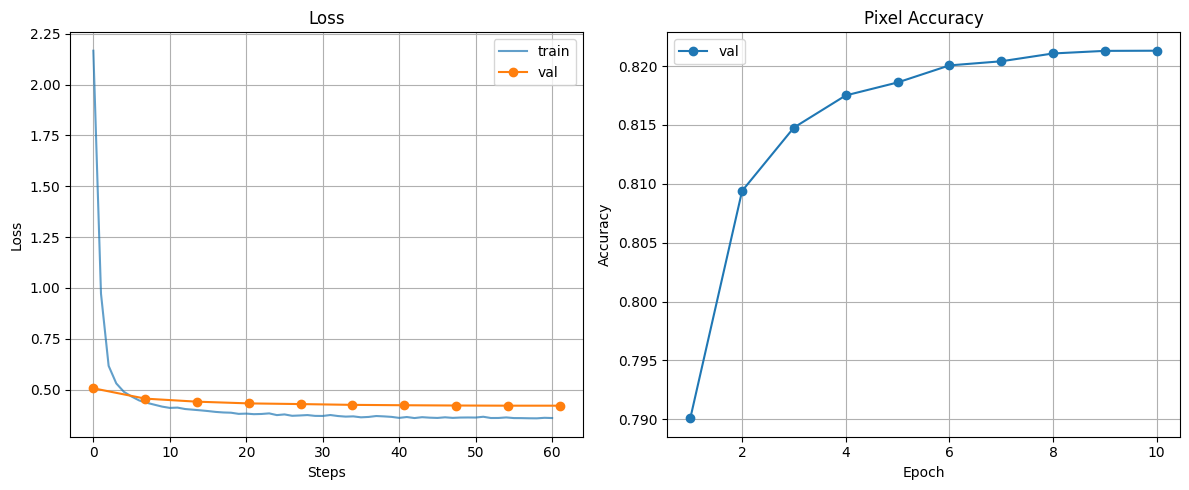

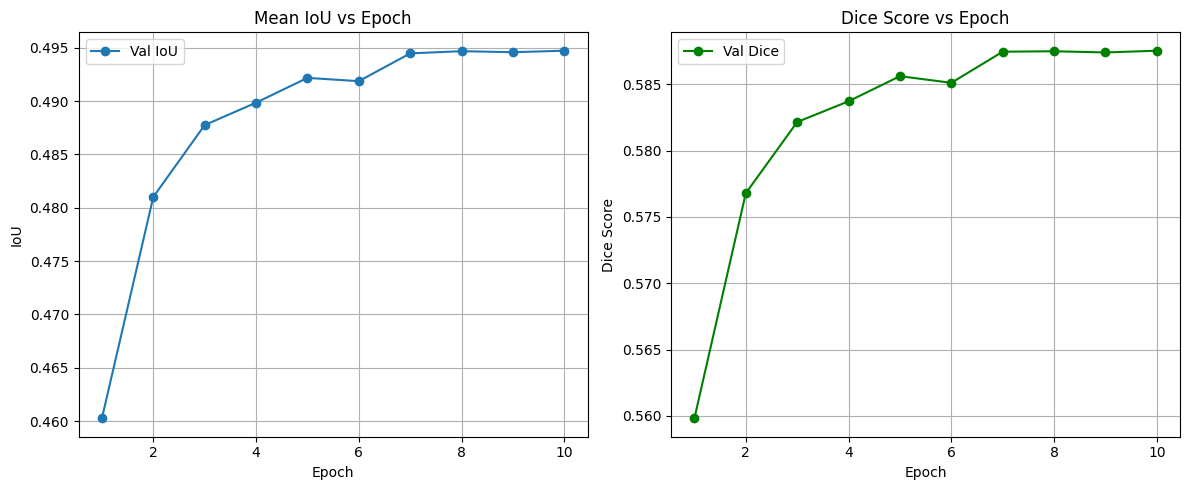

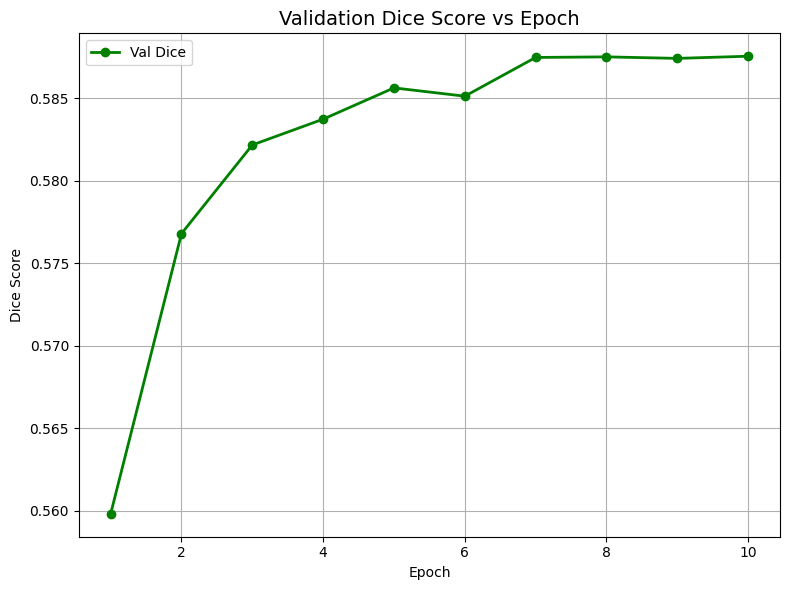

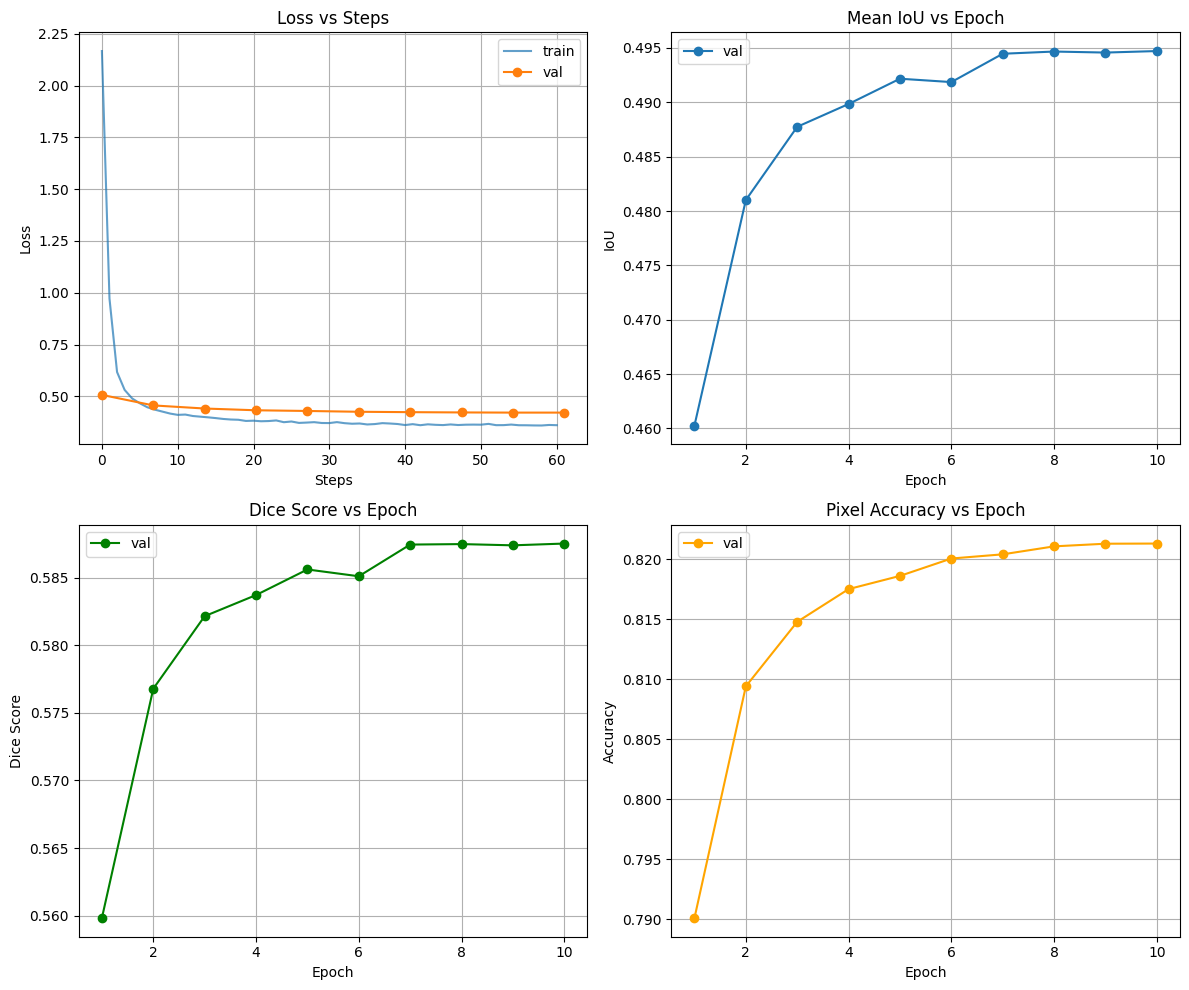

✓ Training curves saved to /kaggle/working/segformer_final_all_aug
✓ Metrics saved to /kaggle/working/segformer_final_all_aug/evaluation_metrics.txt
   ✓ Model saved

📊 Final Evaluation...


In [ ]:

print("\n" + "="*80)
print("🚀 STARTING TRAINING - SEGFORMER-B5")
print("="*80)
print(f"This will take ~6-8 hours on H100")
print(f"Expected final IoU: 0.82-0.85+")
print("="*80 + "\n")


print("\n✅ TRAINING COMPLETE!")

# Save model
print("\n💾 Saving model...")
model.save_pretrained(dir_output / 'final_model')
image_processor.save_pretrained(dir_output / 'final_model')
save_training_plots(trainer, dir_output)
save_history_to_file(trainer, dir_output)
print("   ✓ Model saved")


print("\n📊 Final Evaluation...")